In [2]:
# 자연어 처리 관련 모듈 ------------------------------------------------------------------------
import re
import numpy as np
import pandas as pd
import torch
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset
from konlpy.tag import Okt, Komoran, Kkma


# 시각화 관련 모듈 -----------------------------------------------------------------------------
import matplotlib.pyplot as plt

In [3]:
tokenizer = Komoran()

In [4]:
rawDF = pd.read_csv('../pronunciation_standard.txt', sep='\t')
rawDF.head(5)

,pronunciation,standard
0,오랫동안 한 동네에서 살았던 할무닌데 도라가주씨 매매 아프네요,오랫동안 한 동네에서 살았던 할머니인데 돌아가겨서 마음이 아프네요
1,혈압약은 시간을 맞춰 챙겨 드셔야지 안 그러면 효과가 없습니다,혈압약은 시간을 맞춰 챙겨 드셔야지 안 그러면 효과가 없습니다
2,집에 돌아와 보이꺼네 문이 열려 있고 뼈다지가 열어둔 돈 전부 없어지던 어이떼,집에 돌아와 보니까 문이 열려 있고 서랍이 열어둔 돈 전부 없어지던 어이떼
3,아들 오늘 중요한 시험 보니까네 이 생서 하고 사가꼬 묵고 힘내서 시험 잘 바래이,아들 오늘 중요한 시험 보니까 이 생 엿 하고 사서 먹고 힘내서 시험 잘 봐
4,옛날부터 조상꿈이나 돼지꿈 꾸만 집에 돈 많이 들어온다고 좋아 해찌로,옛날부터 조상꿈이나 돼지꿈 꾸면 집에 돈 많이 들어온다고 좋아 했죠


In [31]:
def cleanTxt(sent):
	# 한글 공백 제외 삭제
	sent = re.sub(r"[^ㄱ-ㅎ가-힣\s]", "", sent)
	return sent

In [32]:
def load_preprocessed_data(tokenizer):
    encoder_input, decoder_input, decoder_target = [], [], []

    with open("../pronunciation_standard.txt", "r") as lines:
        # print(lines)											# <_io.TextIOWrapper name='../dialect_standard.txt' mode='r' encoding='UTF-8'>
        for i, line in enumerate(lines):
            
            # source 데이터와 target 데이터 분리
            if not i: continue									# header 라인 패스
            elif len(line.strip().split('\t'))==2:
                
                # print(line.strip().split('\t'))					# ['혈압약은 시간을', '혈압약은 시간을']
                
				# 표준어 	방언
                src_line, tar_line = line.strip().split('\t')[1], line.strip().split('\t')[0]
                # print(src_line)
                # print(tar_line)
	
				# source 데이터 전처리
                # print(cleanTxt(src_line))
                src_line = [w for w in tokenizer.morphs(cleanTxt(src_line))]
                # print(src_line)
                # break

				# target 데이터 전처리
                tar_line = tokenizer.morphs(cleanTxt(tar_line))
                tar_line_in = [w for w in (["<sos>"] + tar_line)]
                tar_line_out = [w for w in (tar_line + ["<eos>"])]

                encoder_input.append(src_line)
                decoder_input.append(tar_line_in)
                decoder_target.append(tar_line_out)
                

            # if i == len(lines) - 1:
            #     break

    return encoder_input, decoder_input, decoder_target

In [33]:
# tmp = "올해는
#  배치 농사를 망우가 짐장을 할라믄 배치를 좀 사와가 담구야 데겠네"	"올해는
#  배추 농사를 망쳐서 김장을 하려면 배추를 좀 사와서 담궈야 되겠네"

In [34]:
sents_std_in, sents_di_in, sents_di_out = load_preprocessed_data(tokenizer)
print('인코더의 입력 :',sents_std_in[:5])
print('디코더의 입력 :',sents_di_in[:5])
print('디코더의 레이블 :',sents_di_out[:5])


인코더의 입력 : [['오랫동안', '한', '동네', '에서', '살', '았', '던', '할머니', '이', 'ㄴ데', '돌', '아가', '겨', '서', '마음', '이', '아프', '네요'], ['혈압', '약', '은', '시간', '을', '맞추', '어', '챙기', '어', '어', '들', '시', '어야지', '안', '그러면', '효과', '가', '없', '습니다'], ['집', '에', '돌아오', '아', '보', '니까', '문', '이', '열리', '어', '있', '고', '서랍', '이', '열', '어', '두', 'ㄴ', '돈', '전부', '없', '어', '지', '던', '어이', '떼'], ['아들', '오늘', '중요', '하', 'ㄴ', '시험', '보', '니까', '이', '생', '엿', '하', '고', '사서', '먹', '고', '힘', '내', '어서', '시험', '잘', '보', '아'], ['옛날', '부터', '조상', '꿈', '이나', '돼지꿈', '꾸', '면', '집', '에', '돈', '많이', '들어오', 'ㄴ다고', '좋', '아', '하', '았', '죠']]
디코더의 입력 : [['<sos>', '오랫동안', '한', '동네', '에서', '살', '았', '던', '하', 'ㄹ', '무', '이', '니', 'ㄴ데', '도라', '가주', '씨', '매매', '아프', '네요'], ['<sos>', '혈압', '약', '은', '시간', '을', '맞추', '어', '챙기', '어', '어', '들', '시', '어야지', '안', '그러면', '효과', '가', '없', '습니다'], ['<sos>', '집', '에', '돌아오', '아', '보이', '꺼', '네', '문', '이', '열리', '어', '있', '고', '뼈', '다', '지', '가', '열', '어', '두', 'ㄴ', '돈', '전부', '없', '어', '지', '던', '어이', '떼']

In [35]:
def build_vocab(sents):
  word_list = []

  for sent in sents:
      for word in sent:
        word_list.append(word)

  # 각 단어별 등장 빈도를 계산하여 등장 빈도가 높은 순서로 정렬
#   word_counts = Counter(word_list)
#   vocab = sorted(word_counts, key=word_counts.get, reverse=True)
  
  vocab = set(word_list)

  word_to_index = {}
  word_to_index['<PAD>'] = 0
  word_to_index['<UNK>'] = 1

  # 등장 빈도가 높은 단어일수록 낮은 정수를 부여
  for index, word in enumerate(vocab) :
    word_to_index[word] = index + 2

  return word_to_index


In [36]:
src_vocab = build_vocab(sents_std_in)
tar_vocab = build_vocab(sents_di_in + sents_di_out)

src_vocab_size = len(src_vocab)
tar_vocab_size = len(tar_vocab)
print("표준어 단어 집합의 크기 : {:d}, 방언 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

표준어 단어 집합의 크기 : 2366, 방언 단어 집합의 크기 : 4722


In [37]:
index_to_src = {v: k for k, v in src_vocab.items()}
index_to_tar = {v: k for k, v in tar_vocab.items()}

def texts_to_sequences(sents, word_to_index):
  encoded_X_data = []
  for sent in sents:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data


In [38]:
encoder_input = texts_to_sequences(sents_std_in, src_vocab)
decoder_input = texts_to_sequences(sents_di_in, tar_vocab)
decoder_target = texts_to_sequences(sents_di_out, tar_vocab)


In [39]:
# 상위 5개의 샘플에 대해서 정수 인코딩 전, 후 문장 출력
# 인코더 입력이므로 <sos>나 <eos>가 없음
for i, (item1, item2) in zip(range(5), zip(sents_std_in, encoder_input)):
    print(f"Index: {i}, 정수 인코딩 전: {item1}, 정수 인코딩 후: {item2}")


Index: 0, 정수 인코딩 전: ['오랫동안', '한', '동네', '에서', '살', '았', '던', '할머니', '이', 'ㄴ데', '돌', '아가', '겨', '서', '마음', '이', '아프', '네요'], 정수 인코딩 후: [723, 1485, 1737, 1133, 1877, 1342, 181, 1914, 131, 894, 1233, 1140, 2156, 580, 269, 131, 1611, 149]
Index: 1, 정수 인코딩 전: ['혈압', '약', '은', '시간', '을', '맞추', '어', '챙기', '어', '어', '들', '시', '어야지', '안', '그러면', '효과', '가', '없', '습니다'], 정수 인코딩 후: [1743, 152, 981, 1535, 1366, 1694, 1468, 1374, 1468, 1468, 842, 1166, 1954, 1237, 126, 861, 275, 238, 1614]
Index: 2, 정수 인코딩 전: ['집', '에', '돌아오', '아', '보', '니까', '문', '이', '열리', '어', '있', '고', '서랍', '이', '열', '어', '두', 'ㄴ', '돈', '전부', '없', '어', '지', '던', '어이', '떼'], 정수 인코딩 후: [1414, 331, 1797, 2361, 1075, 670, 1740, 131, 246, 1468, 159, 1599, 40, 131, 87, 1468, 2064, 1644, 2285, 2061, 238, 1468, 567, 181, 870, 1785]
Index: 3, 정수 인코딩 전: ['아들', '오늘', '중요', '하', 'ㄴ', '시험', '보', '니까', '이', '생', '엿', '하', '고', '사서', '먹', '고', '힘', '내', '어서', '시험', '잘', '보', '아'], 정수 인코딩 후: [594, 1127, 344, 315, 1644, 693, 1075, 670, 131, 73,

In [40]:
def pad_sequences(sentences, max_len=None):
    # 최대 길이 값이 주어지지 않을 경우 데이터 내 최대 길이로 패딩
    if max_len is None:
        max_len = max([len(sentence) for sentence in sentences])

    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features


In [41]:
encoder_input = pad_sequences(encoder_input)
decoder_input = pad_sequences(decoder_input)
decoder_target = pad_sequences(decoder_target)

In [42]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)


인코더의 입력의 크기(shape) : (15296, 37)
디코더의 입력의 크기(shape) : (15296, 46)
디코더의 레이블의 크기(shape) : (15296, 46)


In [44]:
print([index_to_src[word] for word in encoder_input[12300]])
print([index_to_tar[word] for word in decoder_input[12300]])
print([index_to_tar[word] for word in decoder_target[12300]])


['뱀', '에', '몰리', '면', '병원', '에', '가', '아야지', '된장', '같', '은', '거', '마음', '대로', '바르', '면', '큰일', '나', 'ㅂ니다', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<sos>', '뱀', '에', '몰리', '면', '병원', '에', '가', '아야지', '된장', '같', '은', '거', '마음', '대로', '바르', '면', '큰일', '남', '니', '더', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['뱀', '에', '몰리', '면', '병원', '에', '가', '아야지', '된장', '같', '은', '거', '마음', '대로', '바르', '면', '큰일', '남', '니', '더', '<eos>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [45]:
n_of_train = int(15296*0.7) +1
n_of_val = int(15296*0.2)
n_of_test = int(15296*0.1)


print('훈련 데이터의 개수 :',n_of_train)
print('검증 데이터의 개수 :',n_of_val)
print('테스트 데이터의 개수 :',n_of_test)

print("총합",n_of_train+n_of_val+n_of_test)

훈련 데이터의 개수 : 10708
검증 데이터의 개수 : 3059
테스트 데이터의 개수 : 1529
총합 15296


In [46]:
encoder_input_train = encoder_input[:n_of_train, :]
decoder_input_train = decoder_input[:n_of_train, :]
decoder_target_train = decoder_target[:n_of_train, :]

encoder_input_val = encoder_input[n_of_train:n_of_train+n_of_val+1, :]
decoder_input_val = decoder_input[n_of_train:n_of_train+n_of_val+1, :]
decoder_target_val = decoder_target[n_of_train:n_of_train+n_of_val+1, :]

encoder_input_test = encoder_input[-n_of_test:]
decoder_input_test = decoder_input[-n_of_test:]
decoder_target_test = decoder_target[-n_of_test:]

In [47]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print()
print('검증 source 데이터의 크기 :',encoder_input_val.shape)
print('검증 target 데이터의 크기 :',decoder_input_val.shape)
print('검증 target 레이블의 크기 :',decoder_target_val.shape)
print()
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (10708, 37)
훈련 target 데이터의 크기 : (10708, 46)
훈련 target 레이블의 크기 : (10708, 46)

검증 source 데이터의 크기 : (3060, 37)
검증 target 데이터의 크기 : (3060, 46)
검증 target 레이블의 크기 : (3060, 46)

테스트 source 데이터의 크기 : (1529, 37)
테스트 target 데이터의 크기 : (1529, 46)
테스트 target 레이블의 크기 : (1529, 46)


#### 번역기 만들기

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

embedding_dim = 256
hidden_units = 256

class Encoder(nn.Module):
    def __init__(self, src_vocab_size, embedding_dim, hidden_units):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(src_vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)

    def forward(self, x):
        # x.shape == (batch_size, seq_len, embedding_dim)
        x = self.embedding(x)
        # hidden.shape == (1, batch_size, hidden_units), cell.shape == (1, batch_size, hidden_units)
        _, (hidden, cell) = self.lstm(x)
        # 인코더의 출력은 hidden state, cell state
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, tar_vocab_size, embedding_dim, hidden_units):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(tar_vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)
        self.fc = nn.Linear(hidden_units, tar_vocab_size)

    def forward(self, x, hidden, cell):

        # x.shape == (batch_size, seq_len, embedding_dim)
        x = self.embedding(x)

        # 디코더의 LSTM으로 인코더의 hidden state, cell state를 전달.
        # output.shape == (batch_size, seq_len, hidden_units)
        # hidden.shape == (1, batch_size, hidden_units)
        # cell.shape == (1, batch_size, hidden_units)
        output, (hidden, cell) = self.lstm(x, (hidden, cell))

        # output.shape: (batch_size, seq_len, tar_vocab_size)
        output = self.fc(output)

        # 디코더의 출력은 예측값, hidden state, cell state
        return output, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        hidden, cell = self.encoder(src)

        # 훈련 중에는 디코더의 출력 중 오직 output만 사용한다.
        output, _, _ = self.decoder(trg, hidden, cell)
        return output




In [49]:
encoder = Encoder(src_vocab_size, embedding_dim, hidden_units)
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_units)
model = Seq2Seq(encoder, decoder)

LR = 0.001
loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [50]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2366, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(4722, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=4722, bias=True)
  )
)


In [54]:
def evaluation(model, dataloader, loss_function, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for encoder_inputs, decoder_inputs, decoder_targets in dataloader:
            encoder_inputs = encoder_inputs.to(device)
            decoder_inputs = decoder_inputs.to(device)
            decoder_targets = decoder_targets.to(device)

            # 순방향 전파
            # outputs.shape == (batch_size, seq_len, tar_vocab_size)
            outputs = model(encoder_inputs, decoder_inputs)

            # 손실 계산
            # outputs.view(-1, outputs.size(-1))의 shape는 (batch_size * seq_len, tar_vocab_size)
            # decoder_targets.view(-1)의 shape는 (batch_size * seq_len)
            loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
            total_loss += loss.item()

            # 정확도 계산 (패딩 토큰 제외)
            mask = decoder_targets != 0
            total_correct += ((outputs.argmax(dim=-1) == decoder_targets) * mask).sum().item()
            total_count += mask.sum().item()

    return total_loss / len(dataloader), total_correct / total_count


In [52]:
encoder_input_train_tensor = torch.tensor(encoder_input_train, dtype=torch.long)
decoder_input_train_tensor = torch.tensor(decoder_input_train, dtype=torch.long)
decoder_target_train_tensor = torch.tensor(decoder_target_train, dtype=torch.long)

encoder_input_val_tensor = torch.tensor(encoder_input_val, dtype=torch.long)
decoder_input_val_tensor = torch.tensor(decoder_input_val, dtype=torch.long)
decoder_target_val_tensor = torch.tensor(decoder_target_val, dtype=torch.long)

# 데이터셋 및 데이터로더 생성
batch_size = 128

train_dataset = TensorDataset(encoder_input_train_tensor, decoder_input_train_tensor, decoder_target_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(encoder_input_val_tensor, decoder_input_val_tensor, decoder_target_val_tensor)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


### 학습 설정

In [53]:
# 학습 설정
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2366, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(4722, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=4722, bias=True)
  )
)

In [55]:
# Training loop
best_val_loss = float('inf')

train_history = {'Loss':[], 'Acc':[]}
valid_history = {'Loss':[], 'Acc':[]}


for epoch in range(num_epochs):
    # 훈련 모드
    model.train()

    for encoder_inputs, decoder_inputs, decoder_targets in train_dataloader:
        encoder_inputs = encoder_inputs.to(device)
        decoder_inputs = decoder_inputs.to(device)
        decoder_targets = decoder_targets.to(device)

        # 기울기 초기화
        optimizer.zero_grad()

        # 순방향 전파
        # outputs.shape == (batch_size, seq_len, tar_vocab_size)
        outputs = model(encoder_inputs, decoder_inputs)

        # 손실 계산 및 역방향 전파
        # outputs.view(-1, outputs.size(-1))의 shape는 (batch_size * seq_len, tar_vocab_size)
        # decoder_targets.view(-1)의 shape는 (batch_size * seq_len)
        loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

    train_loss, train_acc = evaluation(model, train_dataloader, loss_function, device)
    valid_loss, valid_acc = evaluation(model, valid_dataloader, loss_function, device)
    
    train_history['Loss'].append(train_loss)
    train_history['Acc'].append(train_acc)
    
    valid_history['Loss'].append(valid_loss)
    valid_history['Acc'].append(valid_acc)
    
    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if valid_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {valid_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_komoran.pth')


Epoch: 1/20 | Train Loss: 4.7023 | Train Acc: 0.2074 | Valid Loss: 4.7411 | Valid Acc: 0.2044
Validation loss improved from inf to 4.7411. 체크포인트를 저장합니다.
Epoch: 2/20 | Train Loss: 3.2778 | Train Acc: 0.4063 | Valid Loss: 3.3418 | Valid Acc: 0.4012
Validation loss improved from 4.7411 to 3.3418. 체크포인트를 저장합니다.
Epoch: 3/20 | Train Loss: 2.3643 | Train Acc: 0.5933 | Valid Loss: 2.4587 | Valid Acc: 0.5840
Validation loss improved from 3.3418 to 2.4587. 체크포인트를 저장합니다.
Epoch: 4/20 | Train Loss: 1.8511 | Train Acc: 0.6764 | Valid Loss: 1.9736 | Valid Acc: 0.6649
Validation loss improved from 2.4587 to 1.9736. 체크포인트를 저장합니다.
Epoch: 5/20 | Train Loss: 1.5486 | Train Acc: 0.7207 | Valid Loss: 1.6947 | Valid Acc: 0.7090
Validation loss improved from 1.9736 to 1.6947. 체크포인트를 저장합니다.
Epoch: 6/20 | Train Loss: 1.3468 | Train Acc: 0.7440 | Valid Loss: 1.5174 | Valid Acc: 0.7291
Validation loss improved from 1.6947 to 1.5174. 체크포인트를 저장합니다.
Epoch: 7/20 | Train Loss: 1.1938 | Train Acc: 0.7662 | Valid Loss: 

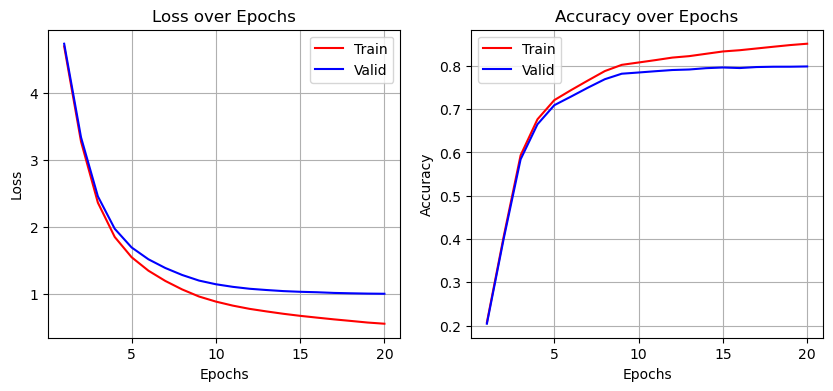

In [56]:
# show plot

TH = len(train_history['Loss'])
plt.figure(figsize=(10, 4))
# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, TH+1), train_history['Loss'], 'r-', label='Train')
plt.plot(range(1, TH+1), valid_history['Loss'], 'b-', label='Valid')
plt.grid()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, TH+1), train_history['Acc'], 'r-', label='Train')
plt.plot(range(1, TH+1), valid_history['Acc'], 'b-', label='Valid')
plt.grid()
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#### 모델 로드

In [57]:
# 모델 로드
model.load_state_dict(torch.load('best_model_komoran.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluation(model, valid_dataloader, loss_function, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')


Best model validation loss: 1.0019
Best model validation accuracy: 0.7985


In [58]:
print(tar_vocab['<sos>'])
print(tar_vocab['<eos>'])


2638
2284


#### seq2seq 번역기 동작시키기

In [60]:
index_to_src = {v: k for k, v in src_vocab.items()}
index_to_tar = {v: k for k, v in tar_vocab.items()}

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_vocab['<sos>'] and encoded_word != tar_vocab['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence


In [ ]:
print(encoder_input_test[25])
print(decoder_input_test[25])
print(decoder_target_test[25])

In [59]:
def decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, max_output_len, int_to_src_token, int_to_tar_token):
    encoder_inputs = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

    # 인코더의 초기 상태 설정
    hidden, cell = model.encoder(encoder_inputs)

    # 시작 토큰 <sos>을 디코더의 첫 입력으로 설정
    # unsqueeze(0)는 배치 차원을 추가하기 위함.
    decoder_input = torch.tensor([2638], dtype=torch.long).unsqueeze(0).to(device)

    decoded_tokens = []

    # for문을 도는 것 == 디코더의 각 시점
    for _ in range(max_output_len):
        output, hidden, cell = model.decoder(decoder_input, hidden, cell)

        # 소프트맥스 회귀를 수행. 예측 단어의 인덱스
        output_token = output.argmax(dim=-1).item()

        # 종료 토큰 <eos>
        if output_token == 2284:
            break

        # 각 시점의 단어(정수)는 decoded_tokens에 누적하였다가 최종 번역 시퀀스로 리턴합니다.
        decoded_tokens.append(output_token)

        # 현재 시점의 예측. 다음 시점의 입력으로 사용된다.
        decoder_input = torch.tensor([output_token], dtype=torch.long).unsqueeze(0).to(device)

    return ' '.join(int_to_tar_token[token] for token in decoded_tokens)


In [ ]:
encoder_input_test[1]

In [62]:
#### 번역 모델 결과 확인
for seq_index in [3, 50, 100, 304, 1004]:
  input_seq = encoder_input_test[seq_index]
  translated_text = decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, 100, index_to_src, index_to_tar)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",translated_text)
  print("-"*50)


입력문장 : 수박 은 크 ㄴ 게 맛있 다고 하 는데 참외 는 작 은 게 맛있 는 거 맛있 다고 작 은 게 맛있 는 거 아니 ㅂ니까 
정답문장 : 수박 은 크 ㄴ 기 맛있 다고 카 는데 참외 는 작 은 게 맛있 는 거 마시 따 꼬 작 은 기 맛있 는 거 아이 이 ㅂ니까 
번역문장 : 수박 은 크 ㄴ 게 맛있 다고 하 는데 참외 는 작 은 게 맛있 는 건 교
--------------------------------------------------
입력문장 : 지금 은 안개 도 짙 고 파도 가 높 아서 배 가 전혀 못 다니 ㄴ다고 하 더라고요 
정답문장 : 지금 은 안개 도 짙 고 파도 가 높 아서 배 가 전혀 못 다니 ㄴ다고 하 더라 꼬 요 
번역문장 : 지금 안 기 도 짙 고 파도 가 노파 가 배 가 만 괴 못 댕기 ㄴ다 꼬 하대 예
--------------------------------------------------
입력문장 : 요즘 날씨 가 가물 어서 농사 도 못 짓 고 계속 집 에 만 있 어서 정말 답답 하 아 
정답문장 : 오 새 날씨 가 가물 어서 농사 도 몰 ㄴ 짓 고 계속 집 에 만 이 쓰이 께 네 정말 답답 하 아 
번역문장 : 요새 날씨 가 가물 어서 농사 도 못 짓 고 계속 집 에 만 이 쓰 니께 정말 답답 하 네
--------------------------------------------------
입력문장 : 배추 한 포기 키우 는 것 도 이렇 게 힘들 ㄴ데 어머니 는 어떻 게 평생 농사 를 짓 고 살 시 었 을까 
정답문장 : 배치 한 포기 키우 는 것 도 이러쿠럼 힘들 ㄴ디 어 모이 는 우예 펭생 농 새 를 짓 고 살 라 쓸 라 
번역문장 : 배치 한 포기 키우 는 것 도 이러쿠럼 힘들 ㄴ디 어 무 이 는 우예 평생 농사 를 짓 고 살 았 을라
--------------------------------------------------
입력문장 : 여기 는 시골 이 라 교통 이 좀 불편 하 ㄴ데 공기 도 깨끗 하 고 경치 가 참

In [63]:
#### 번역 모델 결과 확인
for seq_index in [3, 50, 100, 304, 1004]:
  input_seq = encoder_input_test[seq_index]
  translated_text = decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, 100, index_to_src, index_to_tar)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("번역문장 :",translated_text)
  print("-"*50)

입력문장 : 수박 은 크 ㄴ 게 맛있 다고 하 는데 참외 는 작 은 게 맛있 는 거 맛있 다고 작 은 게 맛있 는 거 아니 ㅂ니까 
번역문장 : 수박 은 크 ㄴ 게 맛있 다고 하 는데 참외 는 작 은 게 맛있 는 건 교
--------------------------------------------------
입력문장 : 지금 은 안개 도 짙 고 파도 가 높 아서 배 가 전혀 못 다니 ㄴ다고 하 더라고요 
번역문장 : 지금 안 기 도 짙 고 파도 가 노파 가 배 가 만 괴 못 댕기 ㄴ다 꼬 하대 예
--------------------------------------------------
입력문장 : 요즘 날씨 가 가물 어서 농사 도 못 짓 고 계속 집 에 만 있 어서 정말 답답 하 아 
번역문장 : 요새 날씨 가 가물 어서 농사 도 못 짓 고 계속 집 에 만 이 쓰 니께 정말 답답 하 네
--------------------------------------------------
입력문장 : 배추 한 포기 키우 는 것 도 이렇 게 힘들 ㄴ데 어머니 는 어떻 게 평생 농사 를 짓 고 살 시 었 을까 
번역문장 : 배치 한 포기 키우 는 것 도 이러쿠럼 힘들 ㄴ디 어 무 이 는 우예 평생 농사 를 짓 고 살 았 을라
--------------------------------------------------
입력문장 : 여기 는 시골 이 라 교통 이 좀 불편 하 ㄴ데 공기 도 깨끗 하 고 경치 가 참 좋 아요 
번역문장 : 여기 는 시골 이 라 교통 이 좀 불편 하 ㄴ디 공기 도 깨 끔 하 고 경치 가 참 조 아예
--------------------------------------------------
